# 카메라 스티커 앱 만들기
---
### 랜드마크(landmark) : 조정(alignment)
- 스티커를 세밀하고 자연스럽게 적용하기 위해서 눈, 코, 입, 귀와 같은 얼굴 각각의 위치들을 찾아내는 기술  
- 조금 더 큰 범위로는 **keypoint detection** 이라 부르고 있다.


In [2]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 


print(cv2.__version__)
print(dlib.__version__)

4.8.0
19.24.0


### OpenCV
- opencv는 영상 관련 업계 표준 라이브러리의 지위를 가지고 있는 아주 강력하고 방대한 기능을 갖춘 컴퓨터 비전 라이브러리  
- opencv는 **BGR** (파랑, 녹색, 빨강) 이미지 채널을 사용한다.

1. 이미지 읽기
    > cv2.imread(fileName, flag)  
    
    **flag**
    - **cv2.IMREAD_COLOR** (1) : 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시 (Default)
    - **cv2.IMREAD_GRAYSCALE** (0) : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.
    - **cv2.IMREAD_UNCHANGED** (-1) : 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.  

2. 이미지 보기
    > cv2.imshow(title, image)

3. 이미지 저장
    > cv2.imwrite('lenagray.png', gray)

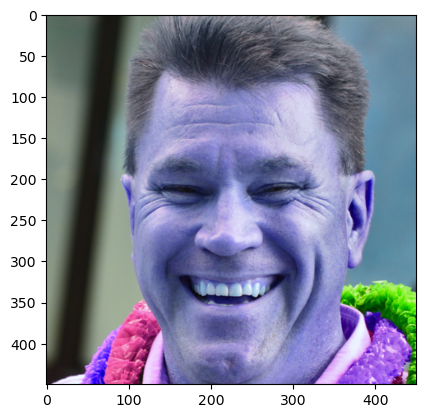

In [3]:
img_bgr = cv2.imread('./images/test01.png')    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

### 색깔 보정 처리
matplotlib, dlib 등의 이미지 라이브러리는 모두 RGB(빨강, 녹색, 파랑) 이미지 채널을 사용하므로  
opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 색깔 보정 처리 필요

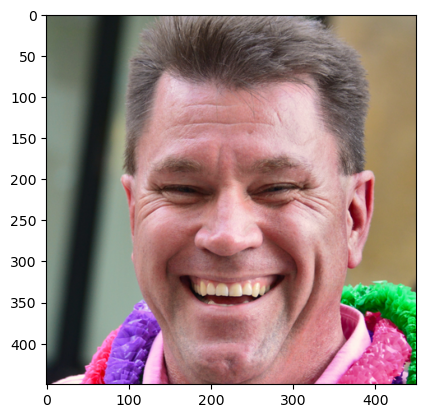

In [4]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

## 얼굴 검출 (face detection)
Object detection 기술을 이용해서 얼굴의 위치를 찾는다  
dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾는다  

#### HOG(Histogram of Oriented Gradients)
HOG는 이미지에서 색상의 변화량을 나타낸 것  
딥러닝이 나오기 이전에 다양하게 사용되던 방식  

이미지에서 단순히 색상값만 가지고 할 수 있는 일이 제한적이었기 때문에 색상의 변화량을 계산한 HOG는 굉장히 큰 도움이 되었습니다.  
이미지로부터 물체의 특징만 잘 잡아내는 능력을 갖출 수 있었거든요.  
2000년대 초반에도 얼굴을 인식해 카메라 초점을 잡는 기능 등에는 모두 이 방식이 응용되었습니다.

### SVM(Support Vector Machine)
SVM은 선형 분류기  
한 이미지를 다차원 공간의 한 벡터라고 보면 여러 이미지는 여러 벡터  
이 여러 벡터를 잘 구분짓는 방법  

### sliding window
작은 영역(window)을 이동해가며 확인하는 방법  
이미지가 크면 클수록 오래걸리는 단점 >> 딥러닝 필요  

rectangles[[(82, 142) (349, 409)]]
left: 82
top: 142
right: 349
bottom: 409
width: 268
height: 268


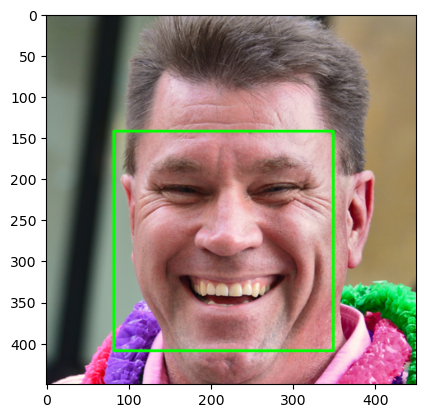

In [5]:
# dlib 를 활용하여 hog detector 선언 : get_frontal_face_detector()
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

# detector_hog를 이용해서 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)
'''
detector_hog 두 번째 파라미터 : 이미지 피라미드의 수
    이미지 피라미드 : 이미지를 upsampling 방법을 통해 크기를 키우는 것
    이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능합니다. 

upsampling이란,
    간단하게 데이터의 크기를 키우는 것 : down sampling의 반대 개념
    down sampling : 일반적으로 CNN의 레이어를 통과하면서 이미지의 크기를 줄이는 것    
    
detector_hog 반환값 : dlib.rectangles 타입의 객체 (dlib.rectangle 객체 배열)

dlib.rectangle객체
    left(), top(), right(), bottom(), height(), width() 등의 멤버 함수를 포함
'''

# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   
print('left:', dlib_rects[0].left())
print('top:', dlib_rects[0].top())
print('right:', dlib_rects[0].right())
print('bottom:', dlib_rects[0].bottom())  
print('width:', dlib_rects[0].width())  
print('height:', dlib_rects[0].height())  

img_landmark = img_show.copy()
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_landmark, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

plt.imshow(cv2.cvtColor(img_landmark, cv2.COLOR_BGR2RGB))
plt.show()

## 얼굴 랜드마크 face landmark
이목구비의 위치를 추론하는 것  
detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용  

### Object keypoint estimation 알고리즘
Face landmark와 같이 객체 내부의 점을 찾는 기술  
1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측
2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

### Dlib landmark location
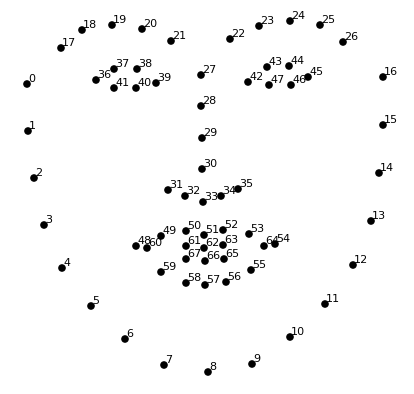  
점의 개수는 데이터셋과 논문마다 다름 (AFLW 데이터셋 21개 사용, ibug 300w 데이터셋 68개 사용)  

Dlib은 **ibug 300-W 데이터셋**으로 학습한 pretrained model 을 제공  
학습 알고리즘은 **regression tree**의 앙상블 모델을 사용  

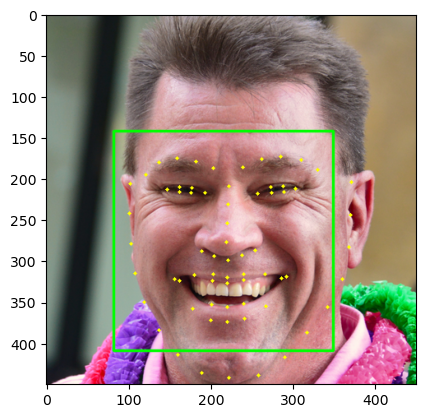

In [6]:
'''
dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
dlib.rectangle: 내부를 예측하는 박스
dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄
'''
landmark_predictor = dlib.shape_predictor('./models/shape_predictor_68_face_landmarks.dat')

# 랜드마크의 위치를 저장할 list
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    # 모든 landmark의 위치정보를 points 변수에 저장
    points = landmark_predictor(img_rgb, dlib_rect)
    
    # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장        
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    
    # list_landmarks에 랜드마크 리스트를 저장        
    list_landmarks.append(list_points)

'''
print(len(list_landmarks[0]))
    얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    각 원소는 68개의 랜드마크 위치가 나열된 list 
    list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생
'''

# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        ''' cv2.circle : OpenCV의 원을 그리는 함수
        img_show 이미지 
        각각의 point에
        크기가 2이고 
        (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
        (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
        '''
        cv2.circle(img_landmark, point, 2, (0, 255, 255), -1)

# RGB 이미지 출력
plt.imshow(cv2.cvtColor(img_landmark, cv2.COLOR_BGR2RGB))
plt.show()

## 스티커 적용하기
---
### 스티커 위치

(x,y) : (219,143)
(w,h) : (268,268)


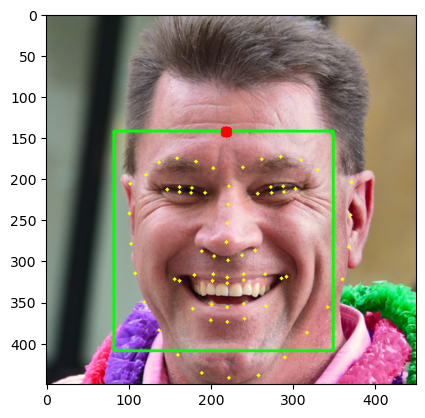

In [7]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# → [[(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 195), (523, 173), (524, 151), (377, 131), (386, 119), (399, 116), (413, 118), (425, 124), (454, 121), (466, 114), (481, 112), (494, 114), (503, 127), (439, 143), (438, 156), (438, 169), (437, 182), (423, 197), (431, 199), (438, 200), (446, 199), (454, 197), (391, 147), (399, 142), (409, 143), (416, 149), (408, 150), (399, 150), (464, 147), (472, 141), (482, 141), (489, 145), (482, 149), (473, 149), (411, 227), (421, 222), (432, 218), (439, 220), (446, 218), (458, 222), (471, 227), (458, 234), (446, 238), (438, 238), (431, 238), (420, 235), (415, 227), (432, 227), (439, 228), (447, 227), (466, 227), (446, 228), (438, 229), (431, 228)]]

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    # 코의 index는 30 입니다
    # 이미지에서 코 부위의 x값
    x = landmark[30][0]
    # 이미지에서 코 부위의 y값 : 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    y = landmark[30][1] - dlib_rect.height()//2 
    # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    w = h = dlib_rect.width() 
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')
    
# 스티커 위치 
cv2.circle(img_landmark, (x, y), 2, (0, 0, 255), 10)
plt.imshow(cv2.cvtColor(img_landmark, cv2.COLOR_BGR2RGB))
plt.show()

### 스티커 적용

(268, 268, 3)
(x,y) : (85,-125)
(x,y) : (85,0)
[[[ 25  26  19]
  [ 25  28  19]
  [ 23  27  18]
  ...
  [100 122 139]
  [103 129 142]
  [107 135 145]]

 [[ 25  26  19]
  [ 25  27  19]
  [ 24  28  19]
  ...
  [101 124 139]
  [101 128 140]
  [108 135 145]]

 [[ 23  27  18]
  [ 25  28  18]
  [ 25  27  20]
  ...
  [101 124 135]
  [103 130 142]
  [107 135 148]]

 ...

 [[113 143 148]
  [117 149 153]
  [122 156 155]
  ...
  [103 107 133]
  [108 113 140]
  [120 126 147]]

 [[116 145 149]
  [119 151 153]
  [120 156 157]
  ...
  [ 84  84 107]
  [ 86  87 111]
  [ 89  92 117]]

 [[117 148 151]
  [120 153 154]
  [121 158 156]
  ...
  [ 98  97 125]
  [ 95  95 118]
  [ 91  94 113]]]


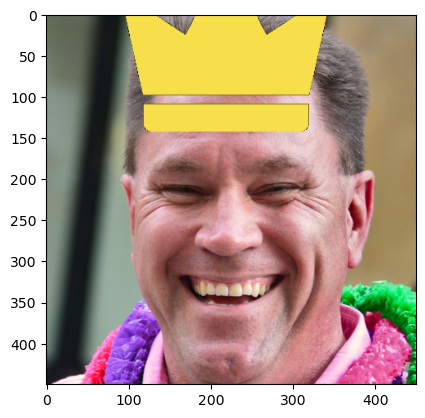

In [9]:
# 스티커 이미지를 불러옵니다
img_sticker = cv2.imread('./images/king.png')

# 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이)) 
img_sticker = cv2.resize(img_sticker, (w,h)) 
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
refined_x = x - w // 2 # 437 - (187//2) = 437-93 = 344
refined_y = y - h # 89-187 = -98
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남
# 우리는 현재 이마 자리에 왕관을 두고 싶은건데, 이마위치 - 왕관 높이를 했더니 이미지의 범위를 초과하여 음수가 나오는 것
# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 왕관 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0
print (f'(x,y) : ({refined_x},{refined_y})')

# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
# 예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미합니다.
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_show[0:0+89, 344:344+187]
# img_show[0:89, 344:531]
# 즉, x좌표는 344~531 / y좌표는 0~89가 됨
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
    
# 왕관 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()
